# Analyse basique de Dataframe de données d'un vol

Projet de statistiques descriptives MACS3, dans le cadre du cours de Jérôme Lacaille.

_Version 1.0 [27/11/2023] Kraemer Valentin_

Prérequis : Fonction de lecture des données de vols avec Dask - TD d'A.Madane

## Analyse de la relation entre les vitesses horizontales et verticales de l'avion et la position du levier.

**Importation des modules utiles pour l'analyse**

In [1]:
%reload_ext autoreload
%autoreload 2

# packages utiles
import sys, glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols

# module
sys.path.append("../")
from src import lire_hdf_dask

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Récupération de la donnée

In [2]:
# chemin vers la donnee 
data_dir = '/home/valentin/Documents/Cours/MACS/MACS3/madane/data/data_extracted/'
filelist = glob.glob(data_dir + '*.h5')

# PARAMETRES DE LA DONNEE 
# Avion
_PLANE = 0

# fonction de lecture de fichier .h5, realise lors des TD d'A.Madane
ddf = lire_hdf_dask(filelist[_PLANE], repertoire= data_dir)

# VOL
_VOL = 0 

# RECUPERATION DU DATAFRAME 
df = ddf.partitions[_VOL].compute()

### Fonctions utiles à la manipulation du DataFrame. 

Outre les fonctions basiques de lecture déjà implémentées lors du TD avec A.Madane, on présente ici les fonctions basiques mises en jeux dans ce travail. Celles-ci seront par la suite stockées dans un modules python adéquat. 

On définit alors la fonction add_speed, qui à un dataframe d'un vol _VOL du l'avion _PLANE ajoute à ce dit dataframe les valeurs des vitesses en ft/s. La fonction add_speed s'écrit alors de la manière suivante: 

In [3]:
def add_speed(df) :
    """
    add_speed function 

    Input : df, dataframe concernant un vol, possédant au moins les colonnes :
        -'M [Mach]'
        -'ALT [ft]'

    Ouput : df, dataframe avec les colonnes supplémentaires : 
        - 'dy [ft/s]' : la vitesse verticale de l'avion 
        - 'dx [ft/s]' : la vitesse horizontale de l'avion 
        - 'ON_AIR'    : un boléen valant True lorsque l'avion est en mouvement
    """

    # facteur de convertion de MACH en Feet/s
    MachToFeetS = 1125.33

    # boleen de mouvement de l'avion 
    ON_AIR = df['M [Mach]']>0

    # gradient des vitesses verticales
    dy= np.empty(len(df))
    y = df['ALT [ft]'].values
    dy[:-1] = y[1:]-y[:-1]
    dy[-1]=0

    # sauvegarde des donnees nouvellement calculees
    df['dy [ft/s]'] =dy
    df['dx [ft/s]'] = df['M [Mach]']*MachToFeetS
    df['ON_AIR'] = ON_AIR
    return df

#### Application : affichage des vitesses horizontales et verticales 

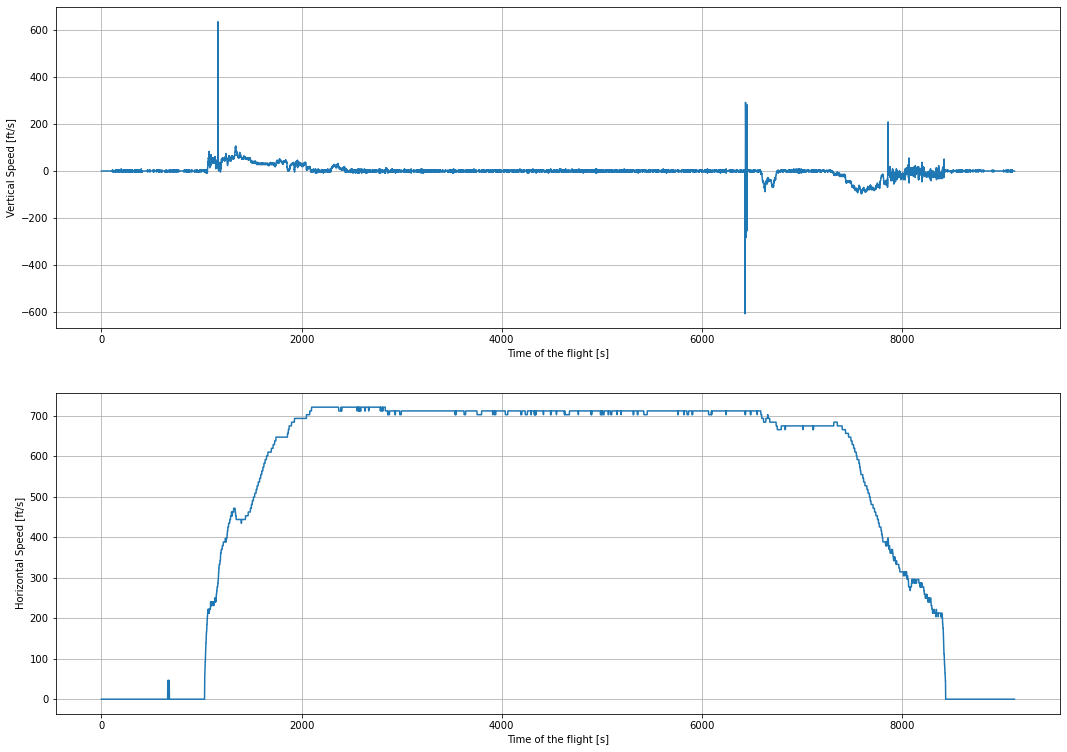

In [4]:
# application de la fonction add_speed
df_speed = add_speed(df)

# affichage graphique 
nb_of_plots = 2
fig, axs = plt.subplots(nb_of_plots, figsize = (18,13))
df_speed['dy [ft/s]'].plot(ax= axs[0], grid = True)
df_speed['dx [ft/s]'].plot(ax = axs[1], grid = True)

labs = ['Vertical Speed [ft/s]', 'Horizontal Speed [ft/s]']
for i, lab in enumerate(labs):
    axs[i].set_ylabel(lab)
    axs[i].set_xlabel('Time of the flight [s]')

Outre les gros pics au niveau de la vitesse verticale, on remarque un comportement cohérent entre la vitesse horizontale et verticale. En effet, lors de la phase de décollage, la vitesse horizotale $v_x$ est croissante et correspond à une ascension de l'avion caractéristique d'une vitesse verticale positive. A contrario, le comportement négatif de la vitesse verticale semble être lié à la descente, représentée par une décélération horizontale de l'avion.

## Problématiques liées aux vitesses et à l'angle du levier

Les deux vitesses précédemment calculées peuvent nous permettre d'obtenir l'angle de l'avion par rapport au sol à partir de la formule suivante :

$$ 
\theta = \arctan(v_y/v_x)
$$

On se propose alors d'étudier cet angle d'attaque en le comparant à la position du levier permettant de piloter l'avion.

On se propose alors de faire une étude naïve du phénomène en caculant cet angle lorsque les vitesses horizontales sont non nulles (d'où l'ajout de la colonne ON_AIR dans la définition de la fonction add_speed). 

On affiche alors le résultat de cette analyse ci-dessous.

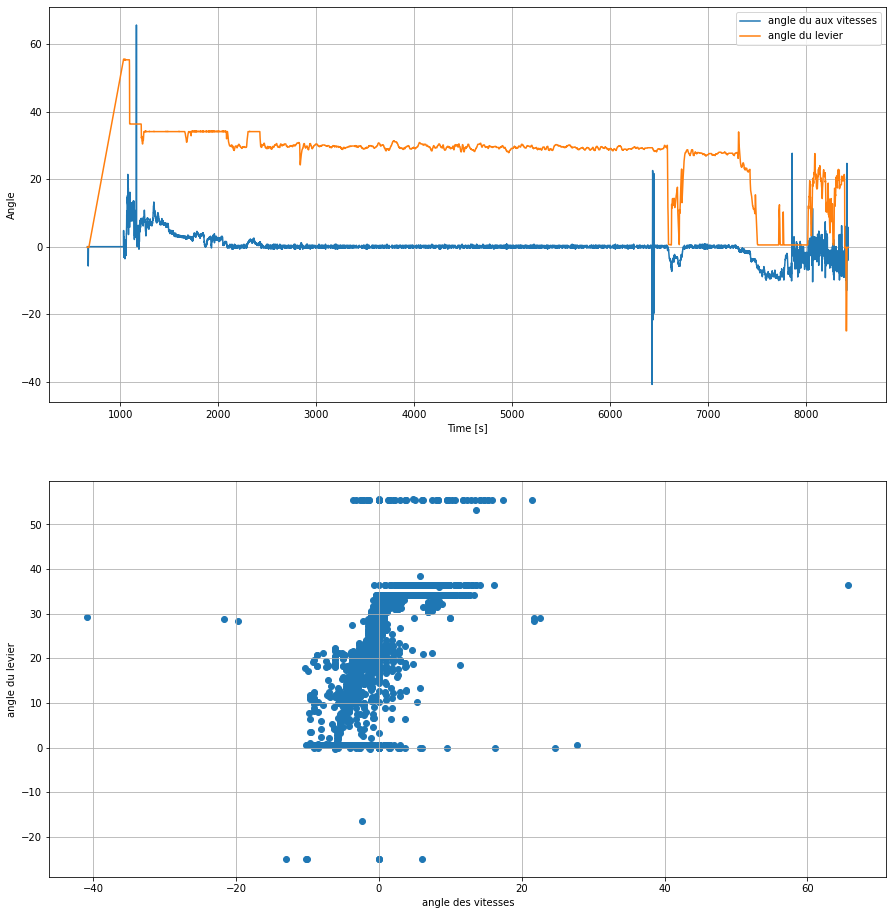

In [5]:
# indices selectionnnes : il s'agit des instants durant lequels l'avion n'est pas immobile
id_study =  df_speed['ON_AIR']
tps = df_speed[id_study].index.values

# stockage des variables d'interet 
vx = df_speed['dx [ft/s]'][id_study].values
vy = df_speed['dy [ft/s]'][id_study].values 
theta = np.arctan(vy/vx)*180/np.pi                      # converti en degres
theta_levier = df_speed['TLA_1 [deg]'][id_study].values 

# affichage graphique
fig, axs = plt.subplots(2, figsize = (15,16))

# evolution temporelle des deux angles 
ax = axs[0]
ax.plot(tps, theta, label = 'angle du aux vitesses' )
ax.plot(tps, theta_levier, label = 'angle du levier')

ax.set_ylabel('Angle')
ax.set_xlabel('Time [s]')
ax.legend()
ax.grid()


# nuage de points entre les deux angles 
ax = axs[1]
ax.scatter(theta, theta_levier)
ax.set_xlabel('angle des vitesses')
ax.set_ylabel('angle du levier')
ax.grid()

Les deux graphes nous laissent à penser un comportement conjoint entre les deux angles présentés ci-contre. Néanmoins, les alignements horizontaux pour $\theta_{levier}$ nous font supposer des bornes mécanique sur l'angle du levier. On peut alors tenter de restreindre notre étude pour des valeurs de levier appartenant à l'intervalle [2, 40] degrés. Cette supposition nous amène alors à l'étude suivante :

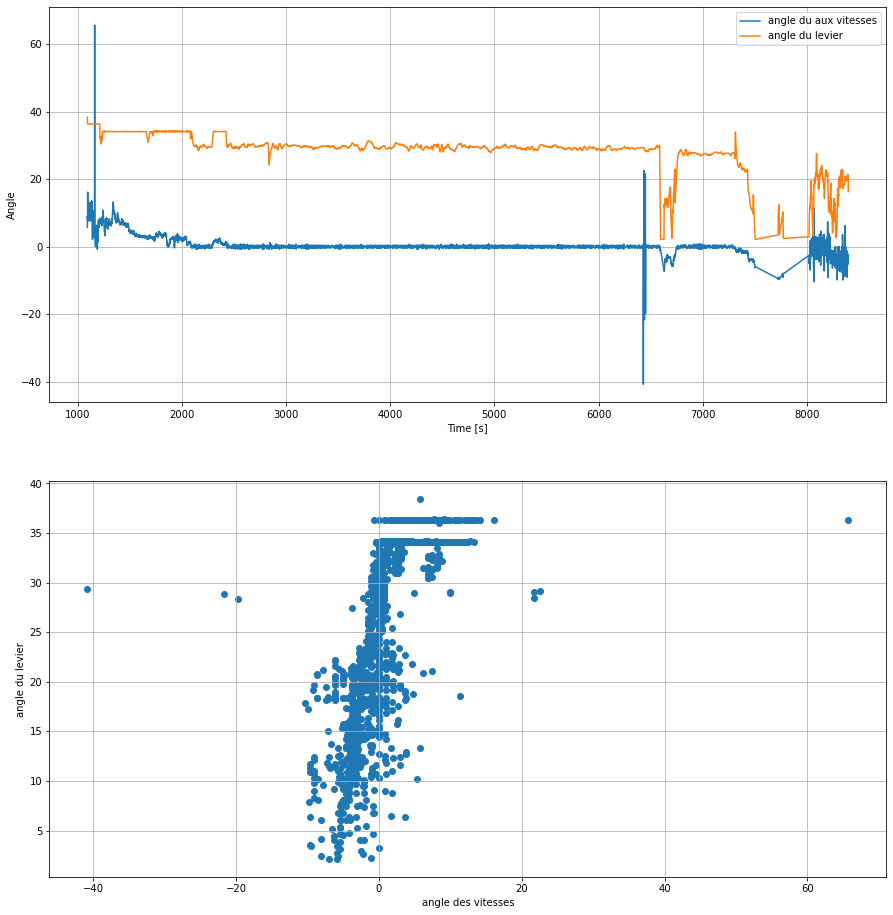

In [6]:
# indices selectionnnes : il s'agit des instants durant lequels l'avion n'est pas immobile
id_on_air =  df_speed['ON_AIR']
id_stick_interval = (df_speed['TLA_1 [deg]']>2) * (df_speed['TLA_1 [deg]']<40)
id_study = id_on_air*id_stick_interval
tps = df_speed[id_study].index.values

# stockage des variables d'interet 
vx = df_speed['dx [ft/s]'][id_study].values
vy = df_speed['dy [ft/s]'][id_study].values 
theta = np.arctan(vy/vx)*180/np.pi                      # converti en degres
theta_levier = df_speed['TLA_1 [deg]'][id_study].values 

# affichage graphique
fig, axs = plt.subplots(2, figsize = (15,16))

# evolution temporelle des deux angles 
ax = axs[0]
ax.plot(tps, theta, label = 'angle du aux vitesses' )
ax.plot(tps, theta_levier, label = 'angle du levier')

ax.set_ylabel('Angle')
ax.set_xlabel('Time [s]')
ax.legend()
ax.grid()


# nuage de points entre les deux angles 
ax = axs[1]
ax.scatter(theta, theta_levier)
ax.set_xlabel('angle des vitesses')
ax.set_ylabel('angle du levier')
ax.grid()

Il semble y avoir une la relation linéaire entre les deux angles. On peut tenter de réduire à nouveau l'angle du levier à 33 degré pour plus de précision. Il s'agirait peut être d'un blocage manuel du levier dans une certaine position, constante lors de la phase ascendante ? 

Tentons alors de faire une regression linéaire basique pour en déduire le $R^2$ ainsi que les coefficients de regressions

### Regression linéaire 

Nous souhaitons faire une regression linéaire entre nos deux angles. Pour ce faire, nous créons un dataframe de regression intermédiaire et utilisons les fonctions de seaborn déjà implémentées. Il vient :

In [7]:
# indices selectionnnes : il s'agit des instants durant lequels l'avion n'est pas immobile
id_on_air =  df_speed['ON_AIR']
id_stick_interval = (df_speed['TLA_1 [deg]']>2) * (df_speed['TLA_1 [deg]']<40)
id_study = id_on_air*id_stick_interval
tps = df_speed[id_study].index.values

# stockage des variables d'interet 
vx = df_speed['dx [ft/s]'][id_study].values
vy = df_speed['dy [ft/s]'][id_study].values 
theta = np.arctan(vy/vx)*180/np.pi                      # converti en degres
theta_levier = df_speed['TLA_1 [deg]'][id_study].values 

# dataframe de regression 
df_reg = pd.DataFrame({'theta_levier': theta_levier, 'theta_vitesse' : theta, 'vx': vx, 'vy':vy, 'time' :tps }).set_index('time')

# regression 
# formule de regression supposee
formula = 'theta_levier~theta_vitesse'

model = ols(data = df_reg, formula = formula).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           theta_levier   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     3789.
Date:                Tue, 28 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:53:14   Log-Likelihood:                -18883.
No. Observations:                6761   AIC:                         3.777e+04
Df Residuals:                    6759   BIC:                         3.778e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        28.3043      0.049    580.241      0.000      28.209      28.400
theta_vitesse     1.1359      0.018     61.557      0.000       1.100       1.172
==============================================================================
Omnibus:                     4729.947   Durbin-Watson:                   0.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           160874.517
Skew:                          -2.916   Prob(JB):                         0.00
Kurtosis:                      26.175   Cond. No.                         2.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Le $R^2$ obtenu est bien évidemment en deçà de nos attentes du faire des deux droites horizontales de $\theta_{levier}$ ainsi que la présence de valeurs non physiques pour l'angle des vitesses de l'avion (40 degres pour une descente d'un avion c'est trop !)

En étant un peu plus restrictif sur les valeurs acceptables d'angle de levier et angle des vitesses, on obtient dans un premier temps les time series et scatter plots suivants :

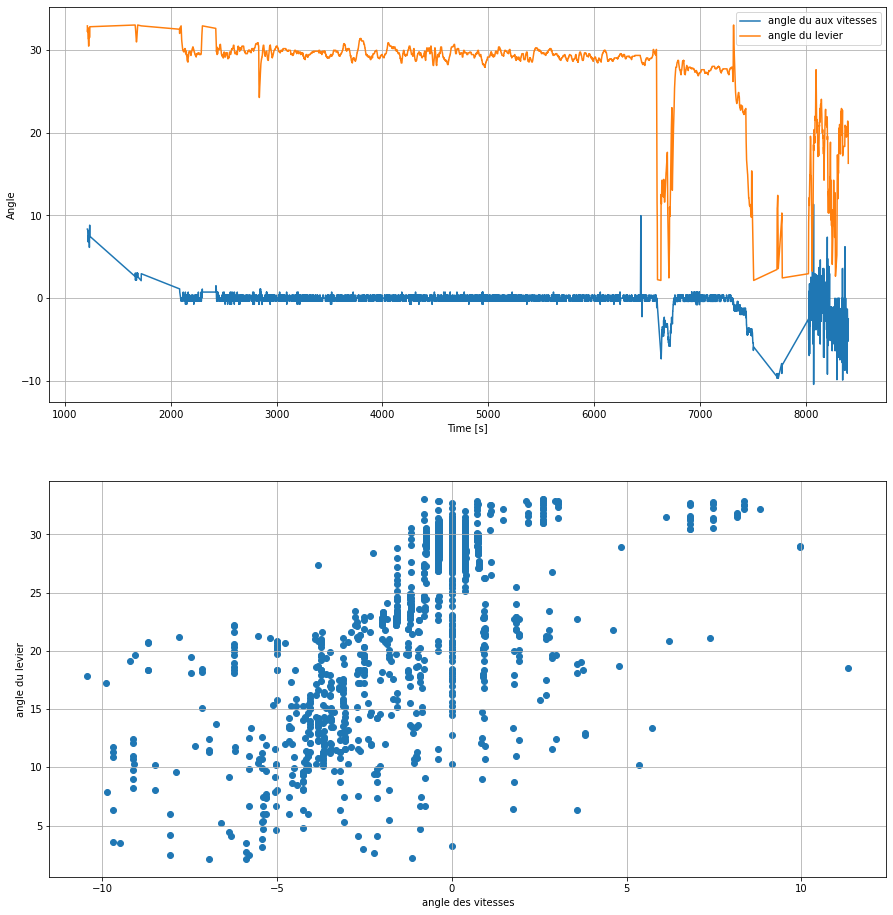

In [8]:
# indices selectionnnes : il s'agit des instants durant lequels l'avion n'est pas immobile
id_on_air =  df_speed['ON_AIR']
id_stick_interval = (df_speed['TLA_1 [deg]']>2) * (df_speed['TLA_1 [deg]']<33)
id_study = id_on_air*id_stick_interval
tps = df_speed[id_study].index.values

# stockage des variables d'interet 
vx = df_speed['dx [ft/s]'][id_study].values
vy = df_speed['dy [ft/s]'][id_study].values 
theta = np.arctan(vy/vx)*180/np.pi                      # converti en degres
theta_levier = df_speed['TLA_1 [deg]'][id_study].values 

# data_frame intermedaire 
df_interm = pd.DataFrame({'theta_levier': theta_levier, 'theta_vitesse' : theta, 'vx': vx, 'vy':vy, 'time' :tps }).set_index('time')
id_physically_admitted = (df_interm['theta_vitesse']>-18)*(df_interm['theta_vitesse']<18)

df_study = df_interm[id_physically_admitted]


# affichage graphique
fig, axs = plt.subplots(2, figsize = (15,16))
tps = df_study.index.values
theta = df_study['theta_vitesse'].values
theta_levier = df_study['theta_levier'].values

# evolution temporelle des deux angles 
ax = axs[0]
ax.plot(tps, theta, label = 'angle du aux vitesses' )
ax.plot(tps, theta_levier, label = 'angle du levier')

ax.set_ylabel('Angle')
ax.set_xlabel('Time [s]')
ax.legend()
ax.grid()


# nuage de points entre les deux angles 
ax = axs[1]
ax.scatter(theta, theta_levier)
ax.set_xlabel('angle des vitesses')
ax.set_ylabel('angle du levier')
ax.grid()

Passons maintenant à la regression sur les données nouvellement créées. 

In [9]:
# regression 
# formule de regression supposee
formula = 'theta_levier~theta_vitesse'

model = ols(data = df_study, formula = formula).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           theta_levier   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     4407.
Date:                Tue, 28 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:53:15   Log-Likelihood:                -15200.
No. Observations:                5678   AIC:                         3.040e+04
Df Residuals:                    5676   BIC:                         3.042e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        28.3282      0.047    596.970      0.000      28.235      28.421
theta_vitesse     2.2121      0.033     66.388      0.000       2.147       2.277
==============================================================================
Omnibus:                     4134.214   Durbin-Watson:                   0.487
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            67270.618
Skew:                          -3.403   Prob(JB):                         0.00
Kurtosis:                      18.428   Cond. No.                         1.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Des biologistes auraient probalement sorti le champagne avant un $R^2$ si élevé.. Cependant, je dois avouer ma déception quant à ces résultats quantitativement si faible. On pourrait alors penser à la réalisation d'une méthode de clustering (cf les notebooks de Félix - il serait également intéressant de faire cette analyse avec un groupby FLIGHT_PHASE) ou à l'ajout d'autres varibles explicatives à l'image du N1/N2 liés aux températures.

### Création de fonctions de généralisation de cette analyse dans le cas d'une analyse multi-vols. 

Dans un but de généralisation de cette anlayse régressive sur tous les vols d'un même avion, on implémente une fonction *angle_analysis* permettant d'itérer le processus de manière automatisée. Celle-ci pourra être utilisée dans le notebook vkr_flight_analysis pour une analyse sur tous les vols d'un même avion. 

In [10]:
def angle_analysis(df, stick_range = [2,33], physical_range = [-18,18]):
    """
    angle_analysis 

    desc : analyse de la relation linéaire entre l'angle des vitesses et l'angle du levier

    Input :
        df : dataframe d'un vol 
        stick_range (facultatif): range de validité du levier où celui-ci n'est pas bloqué
        physical_range (facultatif):  range pour laquelle les angles de l'avion par rapport à la verticale sont physiquement acceptables

    Output : 

    """
    # acquisition des vitesses horizontales et verticales 
    df_speed = add_speed(df)

    # indices selectionnnes : il s'agit des instants durant lequels l'avion n'est pas immobile
    id_on_air =  df_speed['ON_AIR']
    id_stick_interval = (df_speed['TLA_1 [deg]']>stick_range[0]) * (df_speed['TLA_1 [deg]']<stick_range[1])
    id_study = id_on_air*id_stick_interval
    tps = df_speed[id_study].index.values

    # stockage des variables d'interet 
    vx = df_speed['dx [ft/s]'][id_study].values
    vy = df_speed['dy [ft/s]'][id_study].values 
    theta = np.arctan(vy/vx)*180/np.pi                      # converti en degres
    theta_levier = df_speed['TLA_1 [deg]'][id_study].values 

    # data_frame intermedaire 
    df_interm = pd.DataFrame({'theta_levier': theta_levier, 'theta_vitesse' : theta, 'vx': vx, 'vy':vy, 'time' :tps }).set_index('time')
    id_physically_admitted = (df_interm['theta_vitesse']>physical_range[0])*(df_interm['theta_vitesse']<physical_range[1])

    # data_frame d'analyse
    df_study = df_interm[id_physically_admitted]

    return df_study